In [10]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

from ensemblecalibration.utils.plot_functions import safe_literal_eval, process_df

In [93]:
path_t1_old_gp = '../ensemblecalibration/results/gp/final_results_gp/h0_results_gp_old_test_200.csv'
path_t1_new_gp = '../ensemblecalibration/results/gp/final_results_gp/h0_results_gp_new_proper_scores_t1t2_200.csv'
path_t2_old = "../ensemblecalibration/results/gp/final_results_gp/h1_results_gp_old_test_200.csv"
path_t2_new = "../ensemblecalibration/results/gp/final_results_gp/h1_results_gp_new_proper_scores_t1t2_50.csv"

# load data
df_old = pd.read_csv(path_t1_old_gp)
df_new = pd.read_csv(path_t1_new_gp)

df_old_t2 = pd.read_csv(path_t2_old)
df_new_t2 = pd.read_csv(path_t2_new)

In [7]:
df_old

,LP,KL,MMD,SKCE
0,"[np.float64(0.015), np.float64(0.02), np.float...","[np.float64(0.015), np.float64(0.025), np.floa...","[np.float64(0.01), np.float64(0.045), np.float...","[np.float64(0.0), np.float64(0.03), np.float64..."
1,"[np.float64(0.015), np.float64(0.02), np.float...","[np.float64(0.02), np.float64(0.025), np.float...","[np.float64(0.0), np.float64(0.015), np.float6...","[np.float64(0.025), np.float64(0.07), np.float..."


In [11]:
col_names = [ r"$\widehat{\text{CE}}_2^2$", r"$\text{CE}_{KL}$", r"$\text{CE}_{MMD}$", r"$\text{CE}_k$"]

In [12]:
# get two distinct colors from viridis color scheme using seaborn
colors = sns.color_palette("viridis", 2)

In [13]:
def plot_error_analysis(
    list_df: list,
    list_errors=[
        r"$\text{CE}_2$",
        r"$\text{CE}_{KL}$",
        r"$\text{CE}_{MMD}$",
        r"$\text{CE}_k$",
    ],
    list_labels: list = ["Mortier et al.", "Ours"],
    figsize: tuple = (10, 15),
    title=None,
    list_col_titles: list = ["S_0", "S_1", "S_2", "S_3"],
    type_1: bool = True,
    alpha=None,
    colors=colors,
    save_path=None,
):
    # Determine alpha values.
    for df in list_df:
        if "alpha" in df:
            alphas = df["alpha"].values
        elif alpha is not None:
            alphas = alpha
        else:
            alphas = np.array(
                [0.05, 0.13, 0.21, 0.30, 0.38, 0.46, 0.54, 0.62, 0.70, 0.78, 0.87, 0.95]
            )

    # Create subplots.
    if len(list_errors) > 1:
        fig, ax = plt.subplots(
            len(list_errors), len(list_df[0]), figsize=figsize, sharex=True, sharey=True
        )
    else:
        fig, ax = plt.subplots(len(df), figsize=figsize, sharex=True, sharey=True)
        # Ensure ax is iterable (list) in the single error case.
        if not hasattr(ax, "__iter__"):
            ax = [ax]
        else:
            ax = list(ax)

    # Process the dataframe if needed.
    for df in list_df:
        df = process_df(df)

    if len(list_errors) > 1:
        # Multiple error metrics: ax is 2D.
        for i in range(len(list_errors)):
            ax[i, 0].set_ylabel(list_errors[i], fontsize=25)
            
            for k, df in enumerate(list_df):
                for j in range(len(df)):
                    ax[i,j].set_ylim([0, 1])
                    # Get value and process if it is a string.
                    key_df = list(df.keys())
                    val = df[key_df[i]].iloc[j]
                    y_values = safe_literal_eval(val) if isinstance(val, str) else val
                    label = (
                        list_labels[k] if len(list_labels) > 1 else list_labels[0]
                    )
                    ax[i, j].plot(
                        alphas,
                        y_values,
                        linewidth=3.5,
                        marker="x",
                        markersize=12,
                        color=colors[k],
                        label=label,
                    )
                    if type_1:
                        ax[i, j].plot(alphas, alphas, "--", color="black", alpha=0.5)
                    ax[i, j].grid()
                    ax[i, j].spines[["right", "top"]].set_visible(False)

        for i, col_title in enumerate(list_col_titles):
            ax[0, i].set_title(col_title, fontsize=24)
        ax[0, 0].legend(fontsize=18, loc=(-0.1, 0.2))
    else:
        # Single error metric: ax is a 1D array.
        ax[0].set_ylabel(f"{list_errors[0]}", fontsize=22)
        for j in range(len(df)):
            val = df[list_errors[0]].iloc[j]
            y_values = safe_literal_eval(val) if isinstance(val, str) else val
            ax[j].plot(
                alphas, y_values, linewidth=3, marker="x", markersize=10, color="black"
            )
            if j == 0:
                ax[j].plot(alphas, alphas, "--", color="black", alpha=0.5)
            ax[j].grid()
            ax[j].spines[["right", "top"]].set_visible(False)

    fig.supxlabel(r"$\alpha$", fontsize=23, y=0.01)
    if title is not None:
        plt.suptitle(title, fontsize=17, y=0.97)
    fig.subplots_adjust(hspace=0.1)

    # Set tick parameters appropriately.
    if len(list_errors) > 1:
        for i in range(len(list_errors)):
            for j in range(len(df)):
                ax[i, j].tick_params(axis="both", labelsize=20)
    else:
        for j in range(len(df)):
            ax[j].tick_params(axis="both", labelsize=15)

    # grid lines for each subplot
    for i in range(len(list_errors)):
        for j in range(len(df)):
            ax[i, j].grid()
    
    plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=400)

    return fig

In [14]:
# now for dirichlet data
path_t1_old_dir = "../ensemblecalibration/results/dirichlet/final_results_dir/h0_results_dir_old_test_100_final.csv"
path_t1_new_dir = "../ensemblecalibration/results/dirichlet/final_results_dir/h0_results_dirichlet_proper_reg_10_10_200.csv"
path_t1_new_dir_11 = "../ensemblecalibration/results/dirichlet/final_results_dir/h0_results_dirichlet_proper_reg_10_10_100_ll.csv"

path_t2_old_dir = "../ensemblecalibration/results/dirichlet/2025-02-14-19-49-27/h1_results_dir_old_test_100_final.csv"
path_t2_new_dir = "../ensemblecalibration/results/dirichlet/final_results_dir/h1_results_dirichlet_proper_reg_10_10_100.csv"

df_old_dir = pd.read_csv(path_t1_old_dir)
df_new_dir = pd.read_csv(path_t1_new_dir)
df_new_dir_11 = pd.read_csv(path_t1_new_dir_11)

df_old_t2_dir = pd.read_csv(path_t2_old_dir)
df_new_t2_dir = pd.read_csv(path_t2_new_dir)

alpha_t2 = alpha=[0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

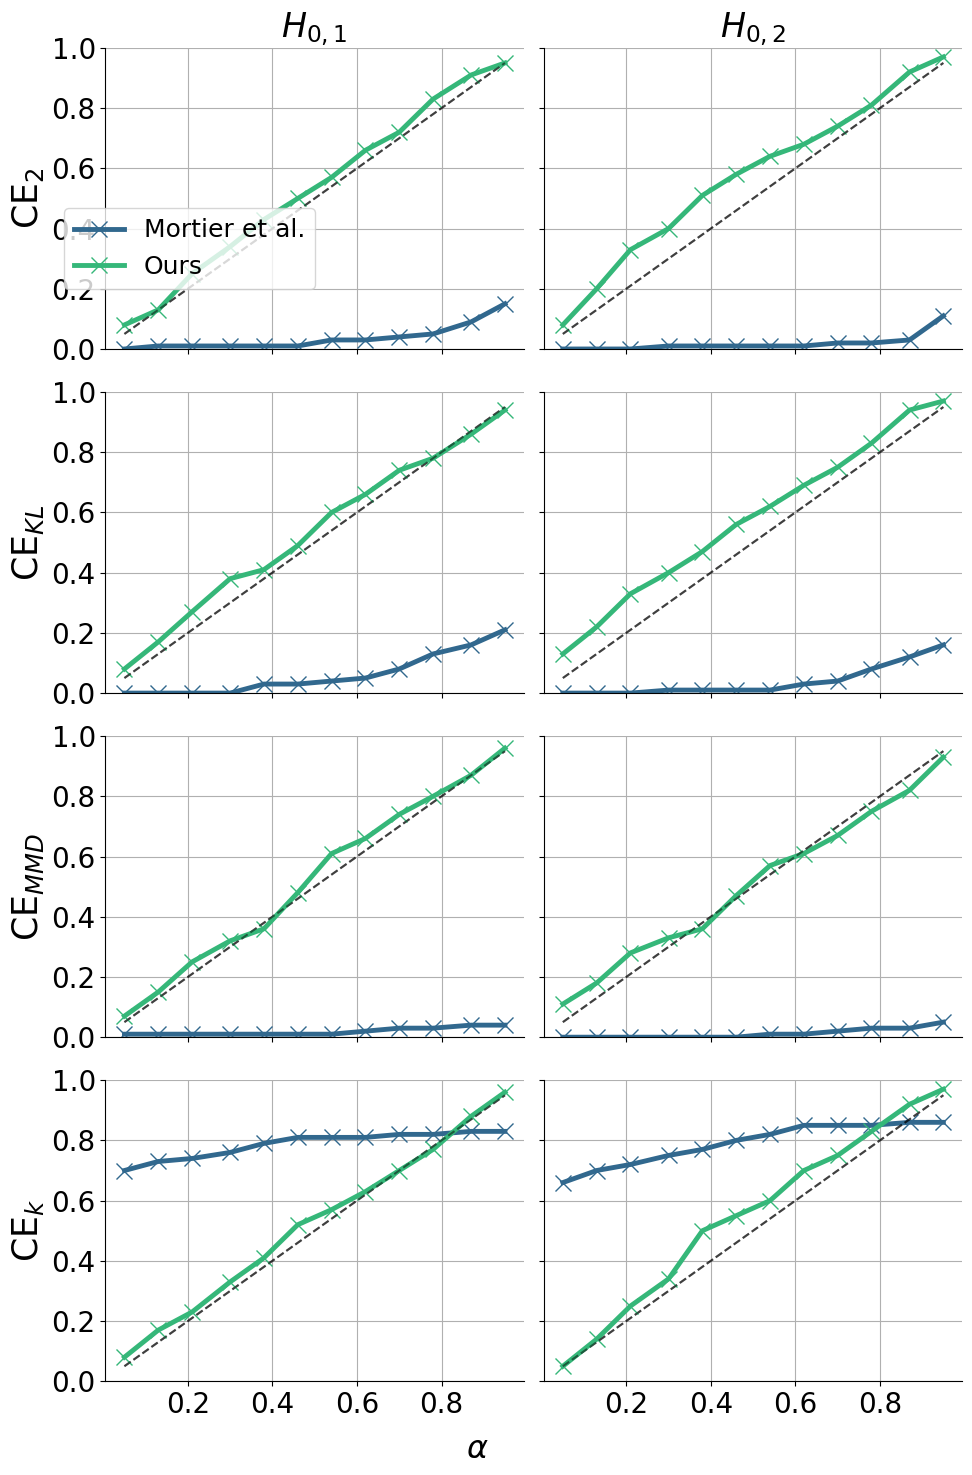

In [20]:
fig_t1_dir = plot_error_analysis([df_old_dir, df_new_dir_11], title='', type_1=True, list_col_titles=[r"$H_{0,1}$", r"$H_{0,2}$"], save_path="../figures/fig_t1_dir.pdf",
                                figsize=(10,15))

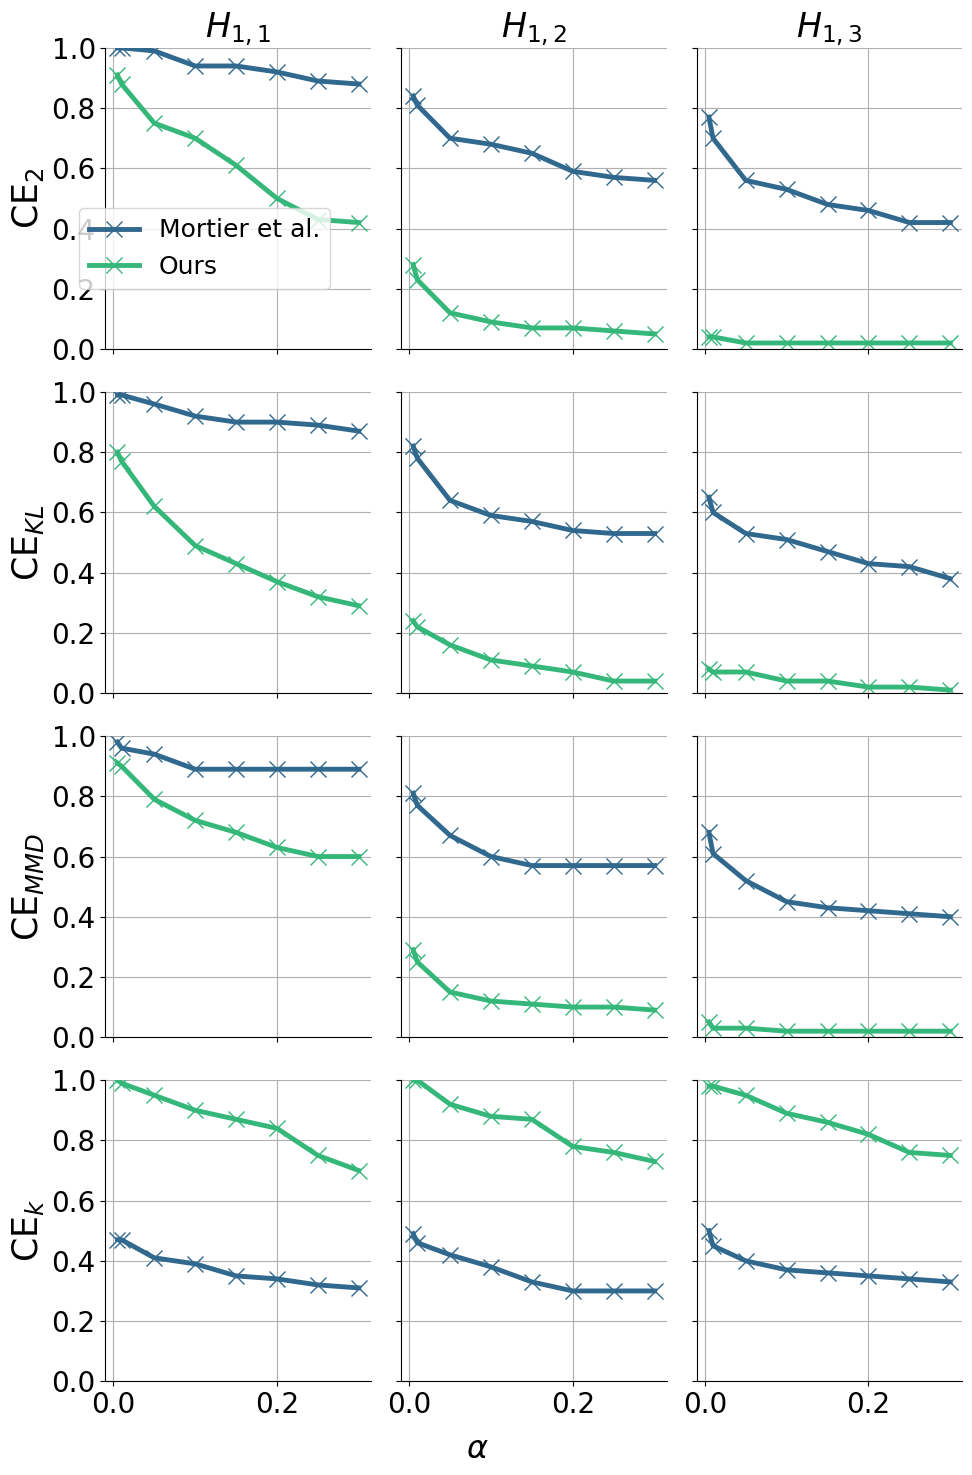

In [19]:
fig_t2_dir = plot_error_analysis([df_old_t2_dir, df_new_t2_dir], title='', type_1=False, list_col_titles=[r"$H_{1,1}$", r"$H_{1,2}$", r"$H_{1,3}$"], save_path="../figures/fig_t2_dir.pdf",
                                alpha=alpha_t2, figsize=(10,15))